In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## LOAD DATA

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save ID columns

train_ID = train['Id']
test_ID = train['Id']

# drop ID columns from dataframes
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

print('Train data shape', train.shape)
print('Test data shape', test.shape)
train.head()

Train data shape (1460, 80)
Test data shape (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data preparation

### Outliers

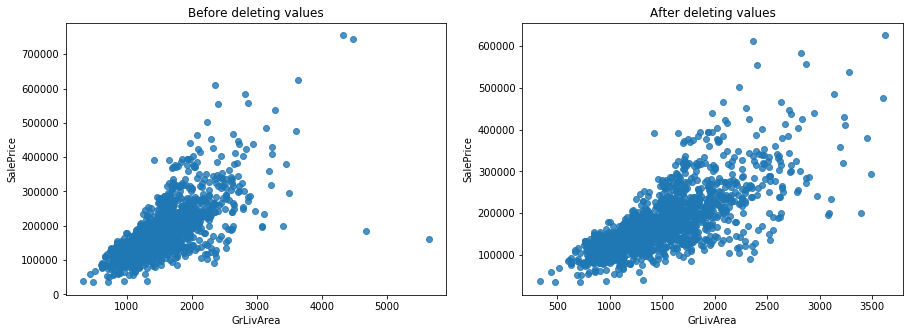

In [16]:
plt.subplots(figsize = (15,5))

plt.subplot(1,2,1)
g = sns.regplot(x= train['GrLivArea'], y= train['SalePrice'], fit_reg = False).set_title('Before deleting values')

# Delete some outliers
plt.subplot(1,2,2)
train = train.drop(train[train['GrLivArea']>4000].index)
g = sns.regplot(x=train['GrLivArea'], y = train['SalePrice'], fit_reg = False).set_title('After deleting values')

### Missing values

In [17]:
ntrain = train.shape[0]
ntest = test.shape[0]

# save the target values
y_train = train.SalePrice.values

# concatenate dataframes
all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop('SalePrice', axis = 1, inplace = True)

print('all_data shape {}'.format(all_data.shape))

all_data shape (2915, 79)


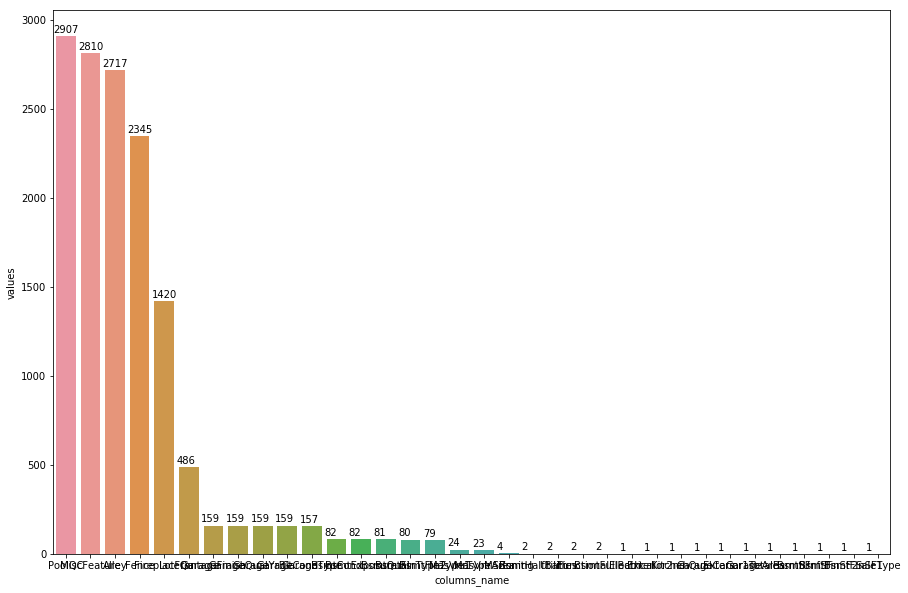

In [46]:
all_data_na = all_data.isnull().sum().sort_values(ascending = False)
all_data_na = pd.DataFrame(all_data_na[all_data_na != 0]).reset_index()
all_data_na.columns = ['columns_name', 'values']


fig, ax = plt.subplots(figsize = (15,10))
ax = sns.barplot(x='columns_name', y='values', data = all_data_na)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()-0.1, height+20, '%.0f'%(height))

### Filling NA values

In [55]:
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print('Filling with NA - Done!')


all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Filling LotFrontage - Done!')


for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print('Filling with 0 - Done!')

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print('Filling with mode - Done!')



Filling with NA - Done!
Filling LotFrontage - Done!
Filling with 0 - Done!
Filling with mode - Done!


In [68]:
all_data_na = all_data.isnull().sum().sort_values(ascending = False)
print('Feature with missing values is ', all_data_na[all_data_na != 0])


Feature with missing values is  Utilities    2
dtype: int64


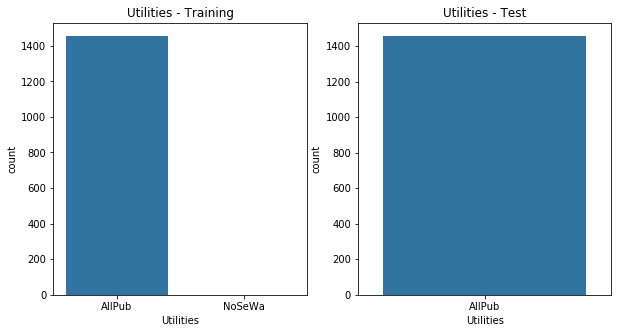

In [69]:
# Let's check the columns Utilities

plt.subplots(figsize = (10,5))
plt.subplot(1,2,1)
ax = sns.countplot(x = 'Utilities', data = train).set_title('Utilities - Training')

plt.subplot(1,2,2)
ax = sns.countplot(x = 'Utilities', data = test).set_title('Utilities - Test')

In [71]:
# In training dataset we have 2 unique values and in test set only one unique value, so we can drop this column
all_data.drop('Utilities', axis = 1, inplace = True)

# Let's check again for missing values
all_data_na = all_data.isnull().sum().sort_values(ascending = False)
print('Feature with missing values is ', all_data_na[all_data_na != 0])

Feature with missing values is  Series([], dtype: int64)


# Exploratory Data Analysis

### Correlation Matrix

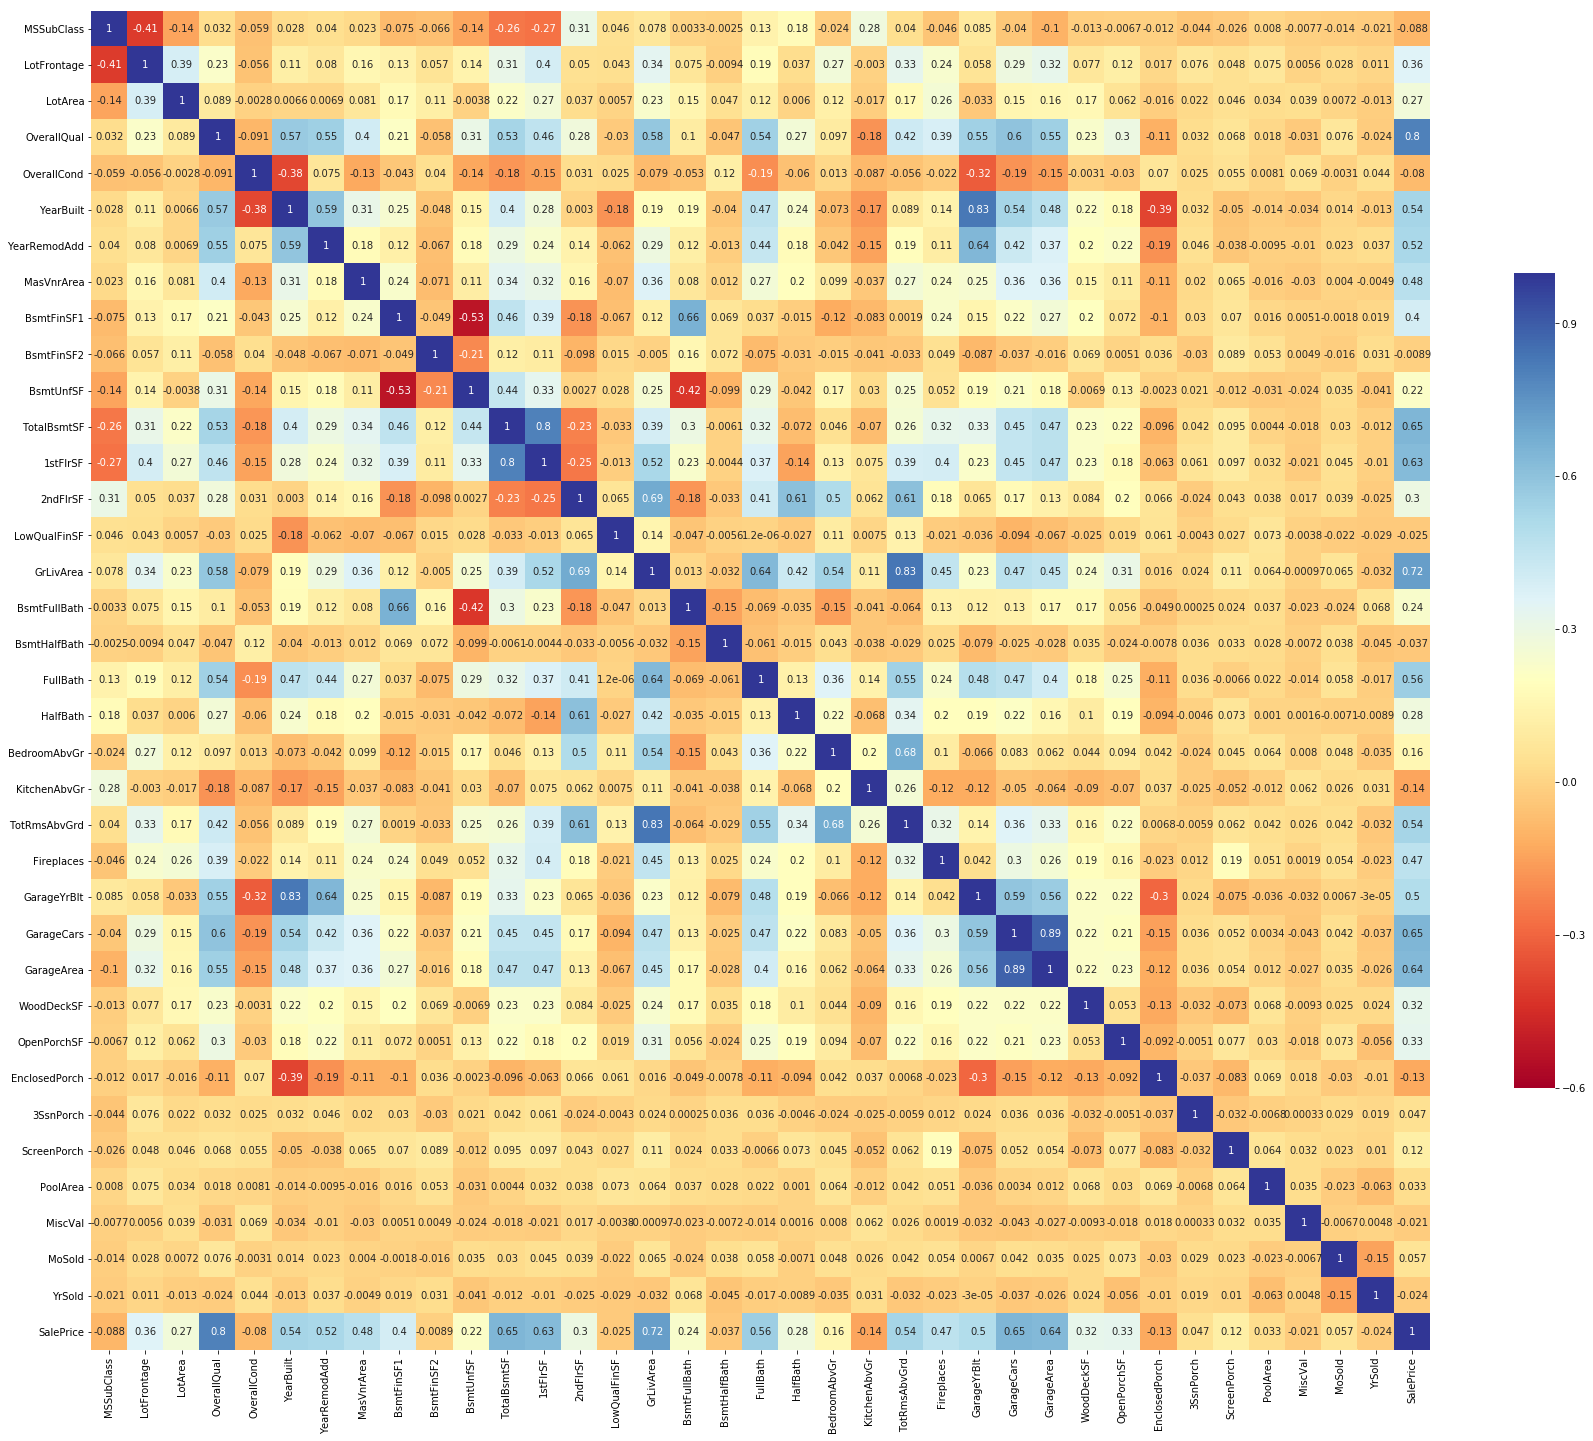

In [75]:
plt.subplots(figsize = (30,30))
#cmap = sns.diverging_palette(150,250, as_cmap=True)
sns.heatmap(train.corr(), cmap="RdYlBu", vmax = 1, vmin = -0.6, center = 0.2, square = True, linewidths=0, 
            cbar_kws={"shrink": .5}, annot = True)